# Image Understanding. Course 2021-2022: Practice 2
### Names: Víctor Morcuende Castell and Antonio Ruiz García
### Group number: 13

## Content-based image retrieval

**Content-based image retrieval** (CBIR) is the mechanism of retrieving images relevant to a given query from a large collection of images known as an image database, based on their semantic or visual content rather than on derived attributes or keyword descriptors prescriptively defined for them.

As shown in the picture there are some basic steps involved in query and retrieval:

- Feature extraction: Of course, this part involves the extraction of image characteristics, such as texture, color, etc. It could also be considered a preprocessing step to, for example, resize or improve the quality of the images.
- Similarity measure: The similarity measurement is used to estimate the query image with the database images by similarity. The dissimilarity between the feature vector of the query image and the database images is calculated using different distance metrics. The higher the dissimilarity, the less similar the two images are. Some commonly used distances are: Euclidean distance, block distance, Minkowski distance and Mahalanobis distance.
- Retrieve the results: The N most similar images are displayed to the user.

![CBIR](https://raw.githubusercontent.com/upm-classes/image-understanding-2021-2022/main/practice2/figures/cbir_01.jpg "CBIR")

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

Labels of the CIFAR10 dataset

In [ ]:
LABELS = {0:'airplane', 
          1: 'automobile',
          2: 'bird',
          3: 'cat',
          4: 'deer',
          5: 'dog',
          6: 'frog',
          7: 'horse',
          8: 'ship',
          9: 'truck'
         }

Load dataset and rescale to a [0, 1] range

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print(f'shape train set: {x_train.shape}, shape test set: {x_test.shape}')

170508288/170498071 [==============================] - 4s 0us/step
shape train set: (50000, 32, 32, 3), shape test set: (10000, 32, 32, 3)


Visualizing the first 10 images of the train set

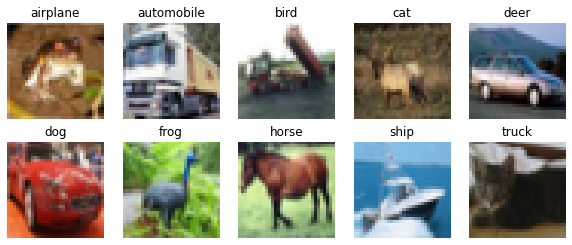

In [ ]:
NUM_IMAGES = 10

fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(NUM_IMAGES):
    im = x_train[i, :, :, :]
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(im)
    ax.set_title(LABELS[i])
    ax.axis('off')
plt.show()

### Feature extraction phase with an autoencoder

An autoencoder is a neural network that is unsupervised which means that doesn't require any labeled data. 

They work by compressing the input into a latent space representation and reconstructing the output from this representation:

- Encoder: the part of the network that compresses the input into a latent space  representation (i.e., representation of compressed data). It can be represented by an encoding function \\( h=f(x) \\).
- Decoder: This part aims to reconstruct the input from the latent space representation. It can be represented by a decoding function \\( r=g(h) \\).

![CBIR Autoencoder](https://raw.githubusercontent.com/upm-classes/image-understanding-2021-2022/main/practice2/figures/cbir_02.jpg "CBIR Autoencoder")

In [ ]:
class Encoder(keras.Model):
    def __init__(self, num_filters=32, latent_dim=128, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = layers.Conv2D(num_filters, kernel_size=3, 
                                   activation="relu", strides=2, padding='same', name='enc_conv1')
        self.conv2 = layers.Conv2D(num_filters * 2, kernel_size=3, 
                                   activation="relu", padding='same', name='enc_conv2')
        self.conv3 = layers.Conv2D(num_filters * 2, kernel_size=3, 
                                   activation="relu", padding='same', strides=2, name='enc_conv3')
        self.conv4 = layers.Conv2D(num_filters * 2, kernel_size=3, 
                                   activation="relu", padding='same', name='enc_conv4')
        self.conv5 = layers.Conv2D(num_filters * 2, kernel_size=3, 
                                   activation="relu", padding='same', strides=2, name='enc_conv5')
        self.flatten = layers.Flatten(name='enc_flatten')
        self.dense = layers.Dense(latent_dim, activation="relu", name='enc_dense')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

encoder = Encoder(num_filters=32, latent_dim=128, name='encoder')
encoder.build((1, 32, 32, 3))
encoder.summary()

class Decoder(keras.Model):
    def __init__(self, num_filters=32, output_channels=3, **kwargs):
        super().__init__(**kwargs)
        self.dense = layers.Dense(16 * num_filters, activation="relu", name='dec_dense')
        self.reshape = layers.Reshape((4, 4, num_filters), name='dec_reshape')
        self.upsam1 = layers.UpSampling2D(size=(2, 2), interpolation="bilinear", name='dec_upsampling1')
        self.conv1 = layers.Conv2D(num_filters * 4, kernel_size=3, activation="relu", 
                                   padding='same', name='dec_conv1')
        self.upsam2 = layers.UpSampling2D(size=(2, 2), interpolation="bilinear", name='dec_upsampling2')
        self.conv2 = layers.Conv2D(num_filters * 2, kernel_size=3, activation="relu", 
                                   padding='same', name='dec_conv2')
        self.upsam3 = layers.UpSampling2D(size=(2, 2), interpolation="bilinear", name='dec_upsampling3')
        self.conv3 = layers.Conv2D(output_channels, kernel_size=3, activation="sigmoid", 
                                   padding='same', name='dec_conv3')
    
    def call(self, x):
        x = self.dense(x)
        x = self.reshape(x)
        x = self.upsam1(x)
        x = self.conv1(x)
        x = self.upsam2(x)
        x = self.conv2(x)
        x = self.upsam3(x)
        x = self.conv3(x)
        return x

decoder = Decoder(num_filters=32, output_channels=3, name='decoder')
decoder.build((1, 128))
decoder.summary()

class AutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    
autoencoder = AutoEncoder(encoder, decoder, name='autoencoder') 
optimizer = Adam()
autoencoder.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mse"])
autoencoder.build((1, 32, 32, 3))
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_conv1 (Conv2D)          multiple                  896       
                                                                 
 enc_conv2 (Conv2D)          multiple                  18496     
                                                                 
 enc_conv3 (Conv2D)          multiple                  36928     
                                                                 
 enc_conv4 (Conv2D)          multiple                  36928     
                                                                 
 enc_conv5 (Conv2D)          multiple                  36928     
                                                                 
 enc_flatten (Flatten)       multiple                  0         
                                                                 
 enc_dense (Dense)           multiple                  1312

In [ ]:
# Download pretrained model
! wget https://github.com/upm-classes/image-understanding-2021-2022/blob/main/practice2/autoencoder_cifar10_2.h5

--2022-05-23 16:04:02--  https://github.com/upm-classes/image-understanding-2021-2022/blob/main/practice2/autoencoder_cifar10_2.h5
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘autoencoder_cifar10_2.h5’

autoencoder_cifar10     [ <=>                ] 125.50K  --.-KB/s    in 0.02s   

2022-05-23 16:04:03 (5.55 MB/s) - ‘autoencoder_cifar10_2.h5’ saved [128514]



In [ ]:
filename = '/content/drive/MyDrive/Image_Understanding/autoencoder_cifar10_2.h5'

if not os.path.exists(filename):
    autoencoder.fit(x_train, x_train,
            epochs=100,
            batch_size=32,
            validation_data=(x_test, x_test))
    autoencoder.save_weights(filename)
else:
    autoencoder.load_weights(filename)

Test how the autoencoder works with N random images

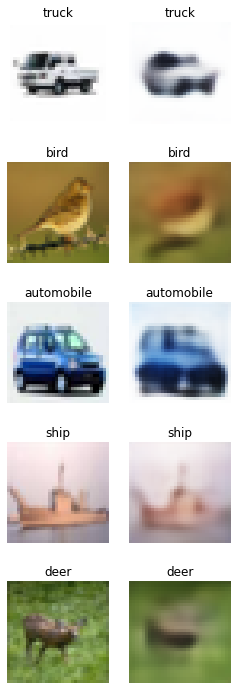

In [ ]:
num_images = 5
idx_random = np.random.choice(x_train.shape[0], num_images)

y_hat = autoencoder.predict(x_train[idx_random])

fig = plt.figure(figsize=(4, num_images*3))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_images):
    im = x_train[idx_random, :, :, :]
    ax1 = fig.add_subplot(6, 2, i * 2 + 1)
    ax1.imshow(x_train[idx_random[i]])
    ax1.set_title(LABELS[y_train[idx_random[i]][0]])
    ax1.axis('off')
    ax2 = fig.add_subplot(6, 2, i * 2 + 2)
    ax2.imshow(y_hat[i])
    ax2.set_title(LABELS[y_train[idx_random[i]][0]])
    ax2.axis('off')
plt.show()

## Similarity calculation and retrieval

This step involves calculating the similarity between all the images of the database and a test image.

As you can imagine this is high-demanding process (calculating all the distances), so there are different techniques that can be used to streamlite this process, such as precalculating the distances, use of distances trees.

As our database is not big, we are going to use for calculating the distance an algorithm called "k-nearest neighbors" (k-NN). k-NN is a non-parametric supervised learning method used for classification that determines the class/label of a new sample by taking into account the k closest training examples in a dataset. When k is set to one (k = 1), then input sample is assigned to the single nearest neighbor.

In our case, we are going to use the distances calculated for k-NN algorithm to retrieve the N most similar images.

In [ ]:
# It takes some time to calculate the features for the train and testing sets

def extract_features(images:np.array) -> np.array:
    # Here we use the encoder to return the latent features of the input images
    feats = encoder.predict(images)
    return feats

train_feats = extract_features(x_train) # Train set
test_feats = extract_features(x_test) # Test set

In [ ]:
# This is our similarity measure, the euclidean distance between x and y. 
# The closer to 0 the more similar x and y are.

def euclidean_distance(x: np.array, y: np.array) -> float:
    distance = np.sum((x-y)**2)
    return distance

In [ ]:
# TODO: Set IDX_SAMPLE to the number of your team

IDX_SAMPLE = 13 # This corresponds to the index of the query image
NUM_SAMPLES = 9 # Number of images to retrieve

query_feats = test_feats[IDX_SAMPLE].reshape(1, -1)    

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
knn = KNeighborsClassifier(n_neighbors=1, metric=euclidean_distance).fit(train_feats, y_train.ravel())
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES, return_distance=True)

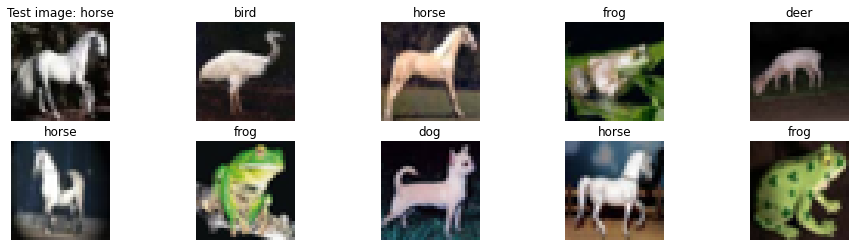

In [ ]:
# Visualization of the images
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(2, 5, 1)

ax.imshow(x_test[IDX_SAMPLE,:,:,:])
ax.set_title(f'Test image: {LABELS[y_test[IDX_SAMPLE][0]]}')
ax.axis('off')
for i in range(NUM_SAMPLES):
    im = x_train[np.squeeze(retrieved_idx)[i], :, :, :]
    ax = fig.add_subplot(2, 5, i + 2)
    ax.imshow(im)
    ax.set_title(LABELS[y_train[np.squeeze(retrieved_idx)[i]][0]])
    ax.axis('off')
plt.show()

## Tasks

In [ ]:
# Task: implement a distance based on cosine similarity. 
# Hint: closer images to the sample should have a smaller distance

def cosine_distance(x:np.array, y:np.array) -> float:
    x = x/np.linalg.norm(x)
    y = y/np.linalg.norm(y)
    distance = 1 - (np.dot(x,y)/(np.sqrt(np.dot(x,x))*np.sqrt(np.dot(y,y))))
    return distance

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, metric=cosine_distance).fit(train_feats, y_train.ravel())

query_feats = test_feats[IDX_SAMPLE].reshape(1, -1)  

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES, 
                                                    return_distance=True)

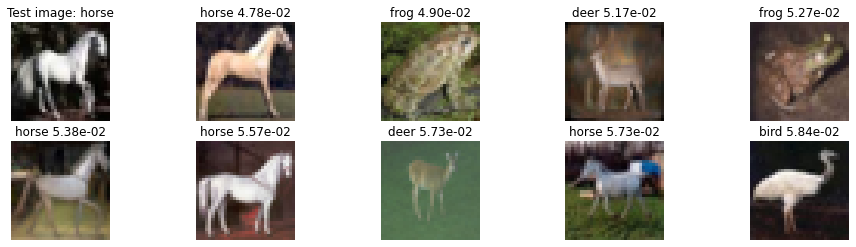

In [ ]:
# Task: Show the distances associated with each retrieved image as part of the subtitle (only 2 decimal places)

def visualize_similar_images(retrieved_idx:np.array, retrieved_distances:np.array) -> None:
    fig = plt.figure(figsize=(16, 4))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    ax = fig.add_subplot(2, 5, 1)

    ax.imshow(x_test[IDX_SAMPLE,:,:,:])
    ax.set_title(f'Test image: {LABELS[y_test[IDX_SAMPLE][0]]}')
    ax.axis('off')
    for i in range(NUM_SAMPLES):
        im = x_train[np.squeeze(retrieved_idx)[i], :, :, :]
        ax = fig.add_subplot(2, 5, i + 2)
        ax.imshow(im)
        ax.set_title(LABELS[y_train[np.squeeze(retrieved_idx)[i]][0]] + " "+ format(retrieved_distances[0][i], ".2e"))
        ax.axis('off')
    plt.show()
    
visualize_similar_images(retrieved_idx, retrieved_distances)

#### Using raw pixels as features

In [ ]:
# TODO: Implement the function to use the raw pixels as features

def extract_features_raw(images:np.array) -> np.array:
    feats = np.reshape(images,(len(images),32*32*3)) # TODO. Hint the shape of the output should be: [N, 32x32x3]
    return feats

train_feats_raw = extract_features_raw(x_train) # Train set
test_feats_raw = extract_features_raw(x_test) # Test set

Show the results with raw pixels using the euclidean distance

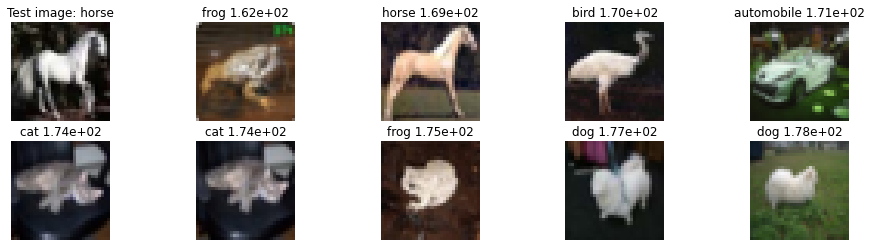

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, metric=euclidean_distance).fit(train_feats_raw, y_train.ravel())

query_feats_raw = test_feats_raw[IDX_SAMPLE].reshape(1, -1)    

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats_raw, n_neighbors=NUM_SAMPLES, 
                                                    return_distance=True)

visualize_similar_images(retrieved_idx, retrieved_distances)

Show the results with raw pixels using the cosine distance

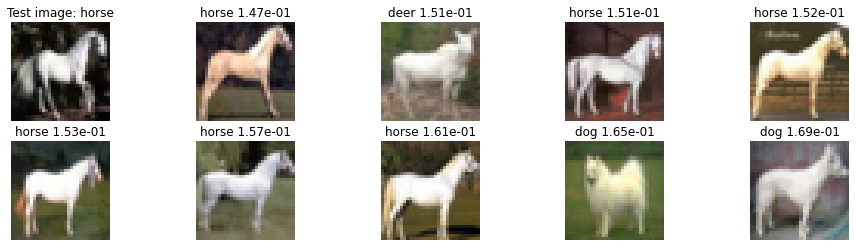

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, metric=cosine_distance).fit(train_feats_raw, y_train.ravel())

query_feats_raw = test_feats_raw[IDX_SAMPLE].reshape(1, -1)    

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats_raw, n_neighbors=NUM_SAMPLES, 
                                                    return_distance=True)

visualize_similar_images(retrieved_idx, retrieved_distances)

#### Using histogram as features

In [ ]:
# TODO: Implement the function to use the histogram as features

def extract_features_hist(images:np.array) -> np.array:
    feats = []
    for im in images:
      for i in range(3):
        feats.append(cv2.calcHist([im],[i],None,[256],[0,1])) # TODO. Hint the shape of the output should be: [N, 256x3]
    feats = np.reshape(feats,(len(images),256*3))
    return feats

train_feats_hist = extract_features_hist(x_train) # Train set
test_feats_hist = extract_features_hist(x_test) # Test set

Show the results with histogram using the euclidean distance

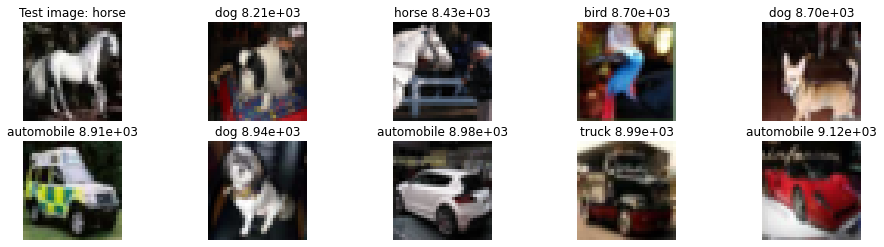

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, metric=euclidean_distance).fit(train_feats_hist, y_train.ravel())

query_feats_hist = test_feats_hist[IDX_SAMPLE].reshape(1, -1)    

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats_hist, n_neighbors=NUM_SAMPLES, 
                                                    return_distance=True)

visualize_similar_images(retrieved_idx, retrieved_distances)

Show the results with histogram using the cosine distance

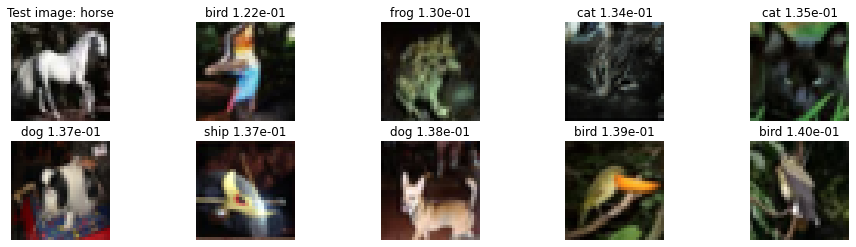

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, metric=cosine_distance).fit(train_feats_hist, y_train.ravel())

query_feats_hist = test_feats_hist[IDX_SAMPLE].reshape(1, -1)    

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats_hist, n_neighbors=NUM_SAMPLES, 
                                                    return_distance=True)

visualize_similar_images(retrieved_idx, retrieved_distances)

Show the results with CNN using the euclidean distance

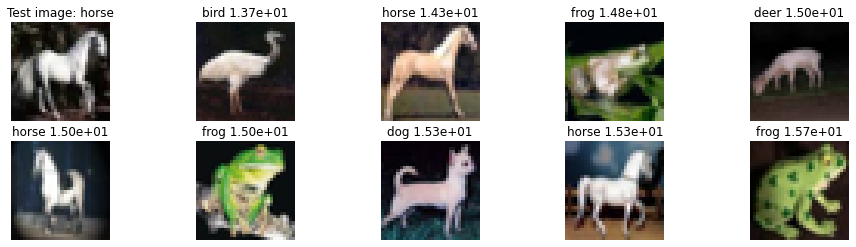

In [ ]:
train_feats = extract_features(x_train) # Train set
test_feats = extract_features(x_test) # Test set

knn = KNeighborsClassifier(n_neighbors=1, metric=euclidean_distance).fit(train_feats, y_train.ravel())

query_feats = test_feats[IDX_SAMPLE].reshape(1, -1)    

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES, 
                                                    return_distance=True)

visualize_similar_images(retrieved_idx, retrieved_distances)

Show the results with CNN using the cosine distance

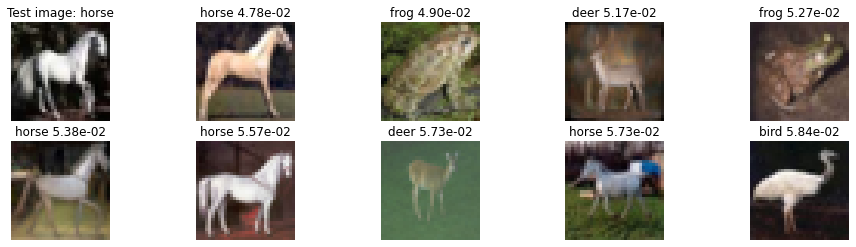

In [ ]:
train_feats = extract_features(x_train) # Train set
test_feats = extract_features(x_test) # Test set

knn = KNeighborsClassifier(n_neighbors=1, metric=cosine_distance).fit(train_feats, y_train.ravel())

query_feats = test_feats[IDX_SAMPLE].reshape(1, -1)

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES, 
                                                    return_distance=True)

visualize_similar_images(retrieved_idx, retrieved_distances)